In [58]:
from collections import Counter
import os
from glob import glob

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [59]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


In [60]:
# Plot an example tree
#Source.from_file('../../../mt-SCITE/mt-SCITE_output/P9855/0.0001/0.0001_map0.gv')

## Clone map

In [61]:
data = [['bulk', 's0', 'P3861_218.clean.dedup_ac.txt', 'ss0'], 
        ['E', 's1', 'P9855_2085_S108_L004_ac.txt', 'ss1'],
        ['A', 's2', 'P9855_2089_S112_L004_ac.txt', 'ss2'],
        ['A', 's3', 'P9855_2090_S113_L004_ac.txt', 'ss3'],
        ['D', 's4', 'P9855_2091_S114_L004_ac.txt', 'ss4'],
        ['E', 's5', 'P9855_2093_S116_L005_ac.txt', 'ss5'],
        ['D', 's6', 'P9855_2096_S119_L005_ac.txt', 'ss6'],
        ['F', 's7', 'P9855_2101_S124_L006_ac.txt', 'ss7'],
        ['F', 's8', 'P9855_2102_S125_L006_ac.txt', 'ss8'],
        ['B', 's9', 'P9855_2104_S127_L006_ac.txt', 'ss9'],
        ['C', 's10', 'P9855_2110_S133_L007_ac.txt', 'ss10'],
        ['C', 's11', 'P9855_2111_S134_L007_ac.txt', 'ss11'],
        ['B', 's12', 'P9855_2112_S135_L007_ac.txt', 'ss12']]

clones_map_raw = pd.DataFrame(data, columns=['clone', 'tree_id', 'cell_id', 'node_name'])

clones_map_raw

clone tree_id                       cell_id node_name
0   bulk      s0  P3861_218.clean.dedup_ac.txt       ss0
1      E      s1   P9855_2085_S108_L004_ac.txt       ss1
2      A      s2   P9855_2089_S112_L004_ac.txt       ss2
3      A      s3   P9855_2090_S113_L004_ac.txt       ss3
4      D      s4   P9855_2091_S114_L004_ac.txt       ss4
5      E      s5   P9855_2093_S116_L005_ac.txt       ss5
6      D      s6   P9855_2096_S119_L005_ac.txt       ss6
7      F      s7   P9855_2101_S124_L006_ac.txt       ss7
8      F      s8   P9855_2102_S125_L006_ac.txt       ss8
9      B      s9   P9855_2104_S127_L006_ac.txt       ss9
10     C     s10   P9855_2110_S133_L007_ac.txt      ss10
11     C     s11   P9855_2111_S134_L007_ac.txt      ss11
12     B     s12   P9855_2112_S135_L007_ac.txt      ss12

In [62]:
clones_map_raw.clone.value_counts()

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

In [63]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [64]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

E       2
A       2
D       2
F       2
B       2
C       2
bulk    1
Name: clone, dtype: int64

## Load tree and pmat data

In [65]:
scite_input_path = '../../../mt-SCITE/mt-SCITE_output/P9855/stdout/'
scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))
#scite_stdout_filenames

In [66]:
pmat_input_path = '../../data/P9855_matrix_output/'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
#pmats

In [67]:
# Get experiment IDs
experiments = []
for filename in sorted(scite_stdout_filenames):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    experiments.append(name)

In [68]:
# Get log likelihood scores
lhood = []
for filename in sorted(scite_stdout_filenames):
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)

In [69]:
# Get n mutations
n_mut = []
for filename in sorted(pmats):
    file = open(filename, "r")
    n = len(file.readlines())
    n_mut.append(n)

In [70]:
error_rates = [f'{0.00005:.5f}', f'{0.00009:.5f}', 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.005, 0.025, 0.03]
#error_rates = [float(i) for i in error_rates]
n_trees = [76, 23, 3, 12, 42, 15, 1, 4, 3, 17, 9, 56, 28, 33, 1, 1]

In [71]:
# Create df
samples = 12
performance = pd.DataFrame(experiments)
performance['lhood'] = lhood
performance['n trees'] = n_trees
performance['n mutations'] = n_mut
performance['lhood'] = performance['lhood'].astype(float)
#tree_data['lhood_mut'] = tree_data['best log score for tree']/tree_data['n mutations']
performance['entries'] = performance['n mutations']*samples
performance['lhood_entries'] = performance['lhood']/performance['entries']
performance = performance.rename(columns={0: 'error_rate'})
performance = performance.set_index('error_rate')
performance

lhood  n trees  n mutations  entries  lhood_entries
error_rate                                                            
0.00005    -12184.181663       76         1018    12216      -0.997395
0.00009     -2034.252282       23          239     2868      -0.709293
0.0001      -1662.422077        3          193     2316      -0.717799
0.0002       -389.108193       12           66      792      -0.491298
0.0003       -129.650810       42           41      492      -0.263518
0.0004       -124.117935       15           34      408      -0.304211
0.0005       -114.786594        1           34      408      -0.281340
0.0006        -60.083862        4           30      360      -0.166900
0.0007        -38.863853        3           28      336      -0.115666
0.0008        -33.511933       17           26      312      -0.107410
0.0009        -34.055324        9           24      288      -0.118248
0.001         -30.651227       56           24      288      -0.106428
0.002         -23.141884       28           22      264      -0.087659
0.005         -20.419492       33           20      240      -0.085081
0.025          -6.826827        1            6       72      -0.094817
0.03           -4.459935        1            3       36      -0.123887

In [72]:
error_rates = performance.index.tolist()
n_trees = performance['n trees'].tolist()
error_rates, n_trees

(['0.00005',
  '0.00009',
  '0.0001',
  '0.0002',
  '0.0003',
  '0.0004',
  '0.0005',
  '0.0006',
  '0.0007',
  '0.0008',
  '0.0009',
  '0.001',
  '0.002',
  '0.005',
  '0.025',
  '0.03'],
 [76, 23, 3, 12, 42, 15, 1, 4, 3, 17, 9, 56, 28, 33, 1, 1])

In [73]:
MAX_TREES_PER_ERROR_RATE = 10

all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/P9855/all_dot_files/{error_rate}_map{idx}.gv'
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[error_rate].append(tree)

In [74]:
performance['tree_size'] = 0
for error_rate, trees in all_trees.items():
    n_nodes = [t.number_of_nodes() for t in trees]
    performance.loc[error_rate, 'tree_size'] = np.mean(n_nodes)

In [75]:
performance

lhood  n trees  n mutations  entries  lhood_entries  \
error_rate                                                               
0.00005    -12184.181663       76         1018    12216      -0.997395   
0.00009     -2034.252282       23          239     2868      -0.709293   
0.0001      -1662.422077        3          193     2316      -0.717799   
0.0002       -389.108193       12           66      792      -0.491298   
0.0003       -129.650810       42           41      492      -0.263518   
0.0004       -124.117935       15           34      408      -0.304211   
0.0005       -114.786594        1           34      408      -0.281340   
0.0006        -60.083862        4           30      360      -0.166900   
0.0007        -38.863853        3           28      336      -0.115666   
0.0008        -33.511933       17           26      312      -0.107410   
0.0009        -34.055324        9           24      288      -0.118248   
0.001         -30.651227       56           24      288      -0.106428   
0.002         -23.141884       28           22      264      -0.087659   
0.005         -20.419492       33           20      240      -0.085081   
0.025          -6.826827        1            6       72      -0.094817   
0.03           -4.459935        1            3       36      -0.123887   

            tree_size  
error_rate             
0.00005          1032  
0.00009           253  
0.0001            207  
0.0002             80  
0.0003             55  
0.0004             48  
0.0005             48  
0.0006             44  
0.0007             42  
0.0008             40  
0.0009             38  
0.001              38  
0.002              36  
0.005              34  
0.025              20  
0.03               17

In [76]:
t = all_trees['0.0001'][0]

In [77]:
clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
clones_count

!! possible mutation in a leaf: not found 173
!! possible mutation in a leaf: not found 116


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

s0  s1  s2  s3  s4  s5  s6  s7  s8  s9  ...  158  112  138  88  170  42  \
bulk   1   0   0   0   0   0   0   0   0   0  ...    0    0    0   0    0   0   
E      0   1   0   0   0   1   0   0   0   0  ...    2    2    2   2    2   2   
A      0   0   1   1   0   0   0   0   0   0  ...    2    2    2   2    2   2   
D      0   0   0   0   1   0   1   0   0   0  ...    2    2    2   2    2   2   
F      0   0   0   0   0   0   0   1   1   0  ...    2    2    2   2    2   2   
B      0   0   0   0   0   0   0   0   0   1  ...    2    2    2   2    2   2   
C      0   0   0   0   0   0   0   0   0   0  ...    2    2    2   2    2   2   

      81  166  139  194  
bulk   0    0    0    1  
E      2    2    2    2  
A      2    2    2    2  
D      2    2    2    2  
F      2    2    2    2  
B      2    2    2    2  
C      2    2    2    2  

[7 rows x 205 columns]

In [78]:
p = purity(clones_count)
p = p[[c for c in p.columns if c not in clones_map.keys()]]
p

43   40  117   69   57       145   37  131   62   20  ...       158  \
bulk  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  ...  0.000000   
E     0.0  0.0  0.0  0.0  0.0  0.166667  0.0  0.0  0.0  0.0  ...  0.166667   
A     0.0  0.0  0.0  0.0  0.0  0.166667  0.0  0.0  0.0  0.0  ...  0.166667   
D     0.0  0.0  0.0  0.0  0.0  0.166667  0.0  0.0  0.0  0.0  ...  0.166667   
F     0.0  0.0  0.0  0.0  0.0  0.166667  0.0  0.0  0.0  0.0  ...  0.166667   
B     0.0  0.0  0.0  0.0  0.0  0.166667  0.0  0.0  0.0  0.0  ...  0.166667   
C     1.0  1.0  1.0  1.0  1.0  0.166667  1.0  1.0  1.0  1.0  ...  0.166667   

           112       138        88       170        42        81       166  \
bulk  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
E     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
A     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
D     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
F     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
B     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
C     0.166667  0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   

           139       194  
bulk  0.000000  0.076923  
E     0.166667  0.153846  
A     0.166667  0.153846  
D     0.166667  0.153846  
F     0.166667  0.153846  
B     0.166667  0.153846  
C     0.166667  0.153846  

[7 rows x 192 columns]

# Avg purity of nodes with >1 sample

In [79]:
performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    n_purities_100 = []
    for t in trees:
        print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation in a leaf: not found 871
!! possible mutation in a leaf: not found 666
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 783
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 682
!! possible mutation in a leaf: not found 232
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 228
!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953
!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 69
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 928
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 964
!! possible mutation in a leaf: not found 889
!! possible mutation in a leaf: not found 560
!! possible mutation in a leaf: not found 129
!! possible mutation in a leaf: not found 929
!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 452
!! possible mutation in a leaf: not found 766
!! possible mutation in a leaf: not found 279
!! possible mutation in a leaf: not found 927
!! possible mutation in a leaf: not found 878
!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: n

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 29
!! possible mutation in a leaf: not found 978
!! possible mutation in a leaf: not found 141
!! possible mutation in a leaf: not found 911
!! possible mutation in a leaf: not found 175
!! possible mutation in a leaf: not found 695
!! possible mutation in a leaf: not found 31
!! possible mutation in a leaf: not found 187
!! possible mutation in a leaf: not found 301
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 747
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 973
!! possible mutation in a leaf: not found 701
!! possible mutation in a leaf: not found 784
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not found 728
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation in a leaf: not found 871
!! possible mutation in a leaf: not found 666
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 783
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 682
!! possible mutation in a leaf: not found 232
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 228
!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953
!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 69
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 928
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 964
!! possible mutation in a leaf: not found 889
!! possible mutation in a leaf: not found 560
!! possible mutation in a leaf: not found 129
!! possible mutation in a leaf: not found 929
!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 452
!! possible mutation in a leaf: not found 766
!! possible mutation in a leaf: not found 279
!! possible mutation in a leaf: not found 927
!! possible mutation in a leaf: not found 878
!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: n

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 29
!! possible mutation in a leaf: not found 978
!! possible mutation in a leaf: not found 141
!! possible mutation in a leaf: not found 911
!! possible mutation in a leaf: not found 175
!! possible mutation in a leaf: not found 695
!! possible mutation in a leaf: not found 31
!! possible mutation in a leaf: not found 187
!! possible mutation in a leaf: not found 301
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 747
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 973
!! possible mutation in a leaf: not found 701
!! possible mutation in a leaf: not found 784
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not found 728
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation in a leaf: not found 871
!! possible mutation in a leaf: not found 666
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 783
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 682
!! possible mutation in a leaf: not found 232
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 228
!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953
!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 35
!! possible mutation in a leaf: not found 394
!! possible mutation in a leaf: not found 162
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204
!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 928
!! possible mutation in a leaf: not found 629
!! possible mutation in a leaf: not found 843
!! possible mutation in a leaf: not found 964
!! possible mutation in a leaf: not found 889
!! possible mutation in a leaf: not found 560
!! possible mutation in a leaf: not found 129
!! possible mutation in a leaf: not found 929
!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 69
!! possible mutation in a leaf: not found 649
!! possible mutation in a leaf: not found 452
!! possible mutation in a leaf: not found 766
!! possible mutation in a leaf: not found 279
!! possible mutation in a leaf: not found 927
!! possible mutation in a leaf: not found 878
!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: n

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 29
!! possible mutation in a leaf: not found 978
!! possible mutation in a leaf: not found 141
!! possible mutation in a leaf: not found 911
!! possible mutation in a leaf: not found 175
!! possible mutation in a leaf: not found 695
!! possible mutation in a leaf: not found 31
!! possible mutation in a leaf: not found 187
!! possible mutation in a leaf: not found 301
!! possible mutation in a leaf: not found 693
!! possible mutation in a leaf: not found 14
!! possible mutation in a leaf: not found 747
!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 973
!! possible mutation in a leaf: not found 701
!! possible mutation in a leaf: not found 784
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not found 728
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation in a leaf: not found 871
!! possible mutation in a leaf: not found 666
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 783
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 682
!! possible mutation in a leaf: not found 232
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 228
!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953
!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not found 35
!! possible mutation in a leaf: not found 394
!! possible mutation in a leaf: not found 162
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 58
!! possible mutation in a leaf: not found 90
!! possible mutation in a leaf: not found 417
!! possible mutation in a leaf: not fou

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 760
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 654
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 110
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 185
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 426
!! possible mutation in a leaf: not found 241
!! possible mutation in a leaf: not found 902
!! possible mutation in a leaf: not found 408
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 22
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 297
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 139
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 82
!! possible mutation in a leaf: not found 317
!! possible mutation in a leaf: not found 487
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not found 688
!! possible mutation in a leaf: not found 494
!! possible mutation in a leaf: not found 294
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 760
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 654
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 110
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 185
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 241
!! possible mutation in a leaf: not found 902
!! possible mutation in a leaf: not found 408
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 22
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 297
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 139
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 82
!! possible mutation in a leaf: not found 317
!! possible mutation in a leaf: not found 487
!! possible mutation in a leaf: not found 278
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not found 688
!! possible mutation in a leaf: not found 494
!! possible mutation in a leaf: not found 294
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 760
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 654
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 110
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 185
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 241
!! possible mutation in a leaf: not found 902
!! possible mutation in a leaf: not found 408
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 22
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 297
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 139
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 82
!! possible mutation in a leaf: not found 317
!! possible mutation in a leaf: not found 487
!! possible mutation in a leaf: not found 278
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not found 688
!! possible mutation in a leaf: not found 494
!! possible mutation in a leaf: not found 294
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 760
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 654
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 110
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 185
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 241
!! possible mutation in a leaf: not found 902
!! possible mutation in a leaf: not found 408
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 22
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 297
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 139
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 82
!! possible mutation in a leaf: not found 317
!! possible mutation in a leaf: not found 487
!! possible mutation in a leaf: not found 278
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not found 688
!! possible mutation in a leaf: not found 494
!! possible mutation in a leaf: not found 294
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 618
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 760
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 654
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 110
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 185
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 241
!! possible mutation in a leaf: not found 902
!! possible mutation in a leaf: not found 408
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 22
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 297
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 139
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 82
!! possible mutation in a leaf: not found 317
!! possible mutation in a leaf: not found 487
!! possible mutation in a leaf: not found 278
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not found 688
!! possible mutation in a leaf: not found 494
!! possible mutation in a leaf: not found 294
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 928
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 618
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 958
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 973
!! possible mutation in a leaf: not found 426
!! possible mutation in a leaf: not found 701
!! possible mutation in a leaf: not found 784
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not found 728
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 585
!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 1019
!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 845
!! possible mutation in a leaf: not found 200
!! possible mutation in a leaf: not found 584
!! possible mutation in a leaf: not found 654
!! possible mutation in a leaf: not found 79
!! possible mutation in a leaf: not found 110
!! possible mutation in a leaf: not found 424
!! possible mutation in a leaf: not found 185
!! possible mutation in a leaf: not found 104
!! possible mutation in a leaf: not found 241
!! possible mutation in a leaf: not found 902
!! possible mutation in a leaf: not found 408
!! possible mutation in a leaf: not found 497
!! possible mutation in a leaf: not found 22
!! possible mutation in a leaf: not found 813
!! possible mutation in a leaf: not found 297
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 367
!! possible mutation in a leaf: not found 139
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 82
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894
!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692
!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 176
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not found 688
!! possible mutation in a leaf: not found 494
!! possible mutation in a leaf: not found 294
!! possible mutation in a leaf: not found 113
!! possible mutation in a leaf: not found 778
!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 564
!! possible mutation in a leaf: not found 446
!! possible mutation in a leaf: not found 772
!! possible mutation in a leaf: not found 412
!! possible mutation in a leaf: not found 336
!! possible mutation in a leaf: not 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 335
!! possible mutation in a leaf: not found 579
!! possible mutation in a leaf: not found 625
!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not found 928
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 618
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764
!! possible mutation in a leaf: not found 958


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: not found 760
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not found 728
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 585
!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 65
0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 65
0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 65
0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 65
0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 65


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 65


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 65


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 65


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 65


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.00009 240
!! possible mutation in a leaf: not found 107
!! possible mutation in a leaf: not found 25
!! possible mutation in a leaf: not found 65


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.0001 194
!! possible mutation in a leaf: not found 173
!! possible mutation in a leaf: not found 116


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.0001 194
!! possible mutation in a leaf: not found 173
!! possible mutation in a leaf: not found 116


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.0001 194
!! possible mutation in a leaf: not found 173
!! possible mutation in a leaf: not found 116


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0002 67
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0003 42
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0004 35
0.0005 35
0.0006 31
0.0006 31
0.0006 31
0.0006 31
0.0007 29
0.0007 29
0.0007 29
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0008 27
0.0009 25
0.0009 25
0.0009 25
0.0009 25
0.0009 25
0.0009 25
0.0009 25
0.0009 25
0.0009 25
0.001 25
0.001 25
0.001 25
0.001 25
0.001 25
0.001 25
0.001 25
0.001 25
0.001 25
0.001 25
0.002 23
0.002 23
0.002 23
0.002 23
0.002 23
0.002 23
0.002 23
0.002 23
0.002 23
0.002 23
0.005 21
0.005 21
0.005 21
0.005 21
0.005 21
0.005 21
0.005 21
0.005 21
0.005 21
0.005 21
0.025 7
0.03 4


# Clone coverage at full purity

In [80]:
performance['min_clone_coverage'] = np.nan
performance['avg_clone_coverage'] = np.nan
for error_rate, trees in all_trees.items():
    t = trees[0]

    clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
    p = purity(clones_count)
    is_pure = p.max(axis=0) == 1.0
    coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
    print(error_rate, '\n', coverage_per_clone, '\n---')
    min_coverage = coverage_per_clone.min()
    avg_coverage = coverage_per_clone.drop('bulk').mean()
    performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
    performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

!! possible mutation in a leaf: not found 668
!! possible mutation in a leaf: not found 792
!! possible mutation in a leaf: not found 54
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 355
!! possible mutation in a leaf: not found 401
!! possible mutation in a leaf: not found 178
!! possible mutation in a leaf: not found 223
!! possible mutation in a leaf: not found 939
!! possible mutation in a leaf: not found 1000
!! possible mutation in a leaf: not found 616
!! possible mutation in a leaf: not found 989
!! possible mutation in a leaf: not found 999
!! possible mutation in a leaf: not found 752
!! possible mutation in a leaf: not found 871
!! possible mutation in a leaf: not found 666
!! possible mutation in a leaf: not found 495
!! possible mutation in a leaf: not found 783
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 682
!! possible mutation in a leaf: not found 232
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 350
!! possible mutation in a leaf: not found 940
!! possible mutation in a leaf: not found 1014
!! possible mutation in a leaf: not found 414
!! possible mutation in a leaf: not found 739
!! possible mutation in a leaf: not found 894


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 731
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 885
!! possible mutation in a leaf: not found 709
!! possible mutation in a leaf: not found 967
!! possible mutation in a leaf: not found 812
!! possible mutation in a leaf: not found 135
!! possible mutation in a leaf: not found 947
!! possible mutation in a leaf: not found 904
!! possible mutation in a leaf: not found 740
!! possible mutation in a leaf: not found 979
!! possible mutation in a leaf: not found 790
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 692


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 626
!! possible mutation in a leaf: not found 366
!! possible mutation in a leaf: not found 699
!! possible mutation in a leaf: not found 222
!! possible mutation in a leaf: not found 140
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 411
!! possible mutation in a leaf: not found 415
!! possible mutation in a leaf: not found 74
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 448
!! possible mutation in a leaf: not found 698
!! possible mutation in a leaf: not found 228
!! possible mutation in a leaf: not found 955
!! possible mutation in a leaf: not found 312
!! possible mutation in a leaf: not found 591
!! possible mutation in a leaf: not found 545
!! possible mutation in a leaf: not found 768
!! possible mutation in a leaf: not found 436
!! possible mutation in a leaf: not found 803
!! possible mutation in a leaf: not found 891
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 373
!! possible mutation in a leaf: not found 696
!! possible mutation in a leaf: not found 943
!! possible mutation in a leaf: not found 638
!! possible mutation in a leaf: not found 770
!! possible mutation in a leaf: not found 318
!! possible mutation in a leaf: not found 953


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 941
!! possible mutation in a leaf: not found 700
!! possible mutation in a leaf: not found 380
!! possible mutation in a leaf: not found 604
!! possible mutation in a leaf: not found 936
!! possible mutation in a leaf: not found 908
!! possible mutation in a leaf: not found 839
!! possible mutation in a leaf: not found 462
!! possible mutation in a leaf: not found 553
!! possible mutation in a leaf: not found 918
!! possible mutation in a leaf: not found 896
!! possible mutation in a leaf: not found 8
!! possible mutation in a leaf: not found 137
!! possible mutation in a leaf: not found 291
!! possible mutation in a leaf: not found 112
!! possible mutation in a leaf: not found 571
!! possible mutation in a leaf: not found 69
!! possible mutation in a leaf: not found 81
!! possible mutation in a leaf: not found 362
!! possible mutation in a leaf: not found 500
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not fo

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 981
!! possible mutation in a leaf: not found 430
!! possible mutation in a leaf: not found 559
!! possible mutation in a leaf: not found 976
!! possible mutation in a leaf: not found 219
!! possible mutation in a leaf: not found 420
!! possible mutation in a leaf: not found 611
!! possible mutation in a leaf: not found 968
!! possible mutation in a leaf: not found 725
!! possible mutation in a leaf: not found 895
!! possible mutation in a leaf: not found 204


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 517
!! possible mutation in a leaf: not found 765
!! possible mutation in a leaf: not found 149
!! possible mutation in a leaf: not found 249
!! possible mutation in a leaf: not found 315
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 598
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 377
!! possible mutation in a leaf: not found 793
!! possible mutation in a leaf: not found 737
!! possible mutation in a leaf: not found 391
!! possible mutation in a leaf: not found 566
!! possible mutation in a leaf: not found 769
!! possible mutation in a leaf: not found 425
!! possible mutation in a leaf: not found 920
!! possible mutation in a leaf: not found 822
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 890
!! possible mutation in a leaf: not found 659
!! possible mutation in a leaf: not found 533
!! possible mutation in a leaf: not

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 470
!! possible mutation in a leaf: not found 461
!! possible mutation in a leaf: not found 543
!! possible mutation in a leaf: not found 7
!! possible mutation in a leaf: not found 91
!! possible mutation in a leaf: not found 602
!! possible mutation in a leaf: not found 872
!! possible mutation in a leaf: not found 465
!! possible mutation in a leaf: not found 156
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 680
!! possible mutation in a leaf: not found 205
!! possible mutation in a leaf: not found 410
!! possible mutation in a leaf: not found 661
!! possible mutation in a leaf: not found 782
!! possible mutation in a leaf: not found 542
!! possible mutation in a leaf: not found 606
!! possible mutation in a leaf: not found 609
!! possible mutation in a leaf: not found 580
!! possible mutation in a leaf: not found 452
!! possible mutation in a leaf: not found 766
!! possible mutation in a leaf: not f

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 89
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 483
!! possible mutation in a leaf: not found 30
!! possible mutation in a leaf: not found 61
!! possible mutation in a leaf: not found 282
!! possible mutation in a leaf: not found 1013
!! possible mutation in a leaf: not found 764


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 958
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 450
!! possible mutation in a leaf: not found 1012
!! possible mutation in a leaf: not found 950
!! possible mutation in a leaf: not found 473
!! possible mutation in a leaf: not found 687
!! possible mutation in a leaf: not found 734
!! possible mutation in a leaf: not found 834
!! possible mutation in a leaf: not found 642
!! possible mutation in a leaf: not found 705
!! possible mutation in a leaf: not found 738
!! possible mutation in a leaf: not found 672
!! possible mutation in a leaf: not found 403
!! possible mutation in a leaf: not found 18
!! possible mutation in a leaf: not found 194
!! possible mutation in a leaf: not found 337
!! possible mutation in a leaf: not found 648
!! possible mutation in a leaf: not found 990
!! possible mutation in a leaf: not found 309
!! possible mutation in a leaf: not found 676
!! possible mutation in a leaf: no

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 807
!! possible mutation in a leaf: not found 973
!! possible mutation in a leaf: not found 701
!! possible mutation in a leaf: not found 784
!! possible mutation in a leaf: not found 869
!! possible mutation in a leaf: not found 189
!! possible mutation in a leaf: not found 728
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 713
!! possible mutation in a leaf: not found 631
!! possible mutation in a leaf: not found 585
!! possible mutation in a leaf: not found 378
!! possible mutation in a leaf: not found 963
!! possible mutation in a leaf: not found 390
!! possible mutation in a leaf: not found 735
!! possible mutation in a leaf: not found 984
!! possible mutation in a leaf: not found 506
!! possible mutation in a leaf: not found 935
0.00005 
 A       1.0
B       0.5
C       0.5
D       0.5
E       0.5
F       0.5
bulk    1.0
dtype: float64 
---
!! possible mutation in a leaf: not found 107
!! possible 

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 65
0.00009 
 A       1.0
B       1.0
C       0.5
D       1.0
E       0.5
F       1.0
bulk    1.0
dtype: float64 
---
!! possible mutation in a leaf: not found 173
!! possible mutation in a leaf: not found 116


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

0.0001 
 A       1.0
B       1.0
C       0.5
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0002 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0003 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0004 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0005 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0006 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0007 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0008 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dtype: float64 
---
0.0009 
 A       1.0
B       1.0
C       1.0
D       1.0
E       1.0
F       0.5
bulk    1.0
dty

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_13698/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]


# Plots

In [81]:
performance

lhood  n trees  n mutations  entries  lhood_entries  \
error_rate                                                               
0.00005    -12184.181663       76         1018    12216      -0.997395   
0.00009     -2034.252282       23          239     2868      -0.709293   
0.0001      -1662.422077        3          193     2316      -0.717799   
0.0002       -389.108193       12           66      792      -0.491298   
0.0003       -129.650810       42           41      492      -0.263518   
0.0004       -124.117935       15           34      408      -0.304211   
0.0005       -114.786594        1           34      408      -0.281340   
0.0006        -60.083862        4           30      360      -0.166900   
0.0007        -38.863853        3           28      336      -0.115666   
0.0008        -33.511933       17           26      312      -0.107410   
0.0009        -34.055324        9           24      288      -0.118248   
0.001         -30.651227       56           24      288      -0.106428   
0.002         -23.141884       28           22      264      -0.087659   
0.005         -20.419492       33           20      240      -0.085081   
0.025          -6.826827        1            6       72      -0.094817   
0.03           -4.459935        1            3       36      -0.123887   

            tree_size  avg_purity_more_than_one_sample  \
error_rate                                               
0.00005          1032                         0.477845   
0.00009           253                         0.679240   
0.0001            207                         0.695680   
0.0002             80                         0.753900   
0.0003             55                         0.749644   
0.0004             48                         0.767988   
0.0005             48                         0.792060   
0.0006             44                         0.794960   
0.0007             42                         0.809066   
0.0008             40                         0.803229   
0.0009             38                         0.787487   
0.001              38                         0.803043   
0.002              36                         0.813811   
0.005              34                         0.796859   
0.025              20                         0.455311   
0.03               17                         0.380128   

            frac_purity_100_more_than_one_sample  min_clone_coverage  \
error_rate                                                             
0.00005                                 0.102326                 0.5   
0.00009                                 0.540000                 0.5   
0.0001                                  0.515789                 0.5   
0.0002                                  0.666667                 0.5   
0.0003                                  0.666667                 0.5   
0.0004                                  0.696970                 0.5   
0.0005                                  0.709677                 0.5   
0.0006                                  0.724138                 0.5   
0.0007                                  0.750000                 0.5   
0.0008                                  0.740741                 0.5   
0.0009                                  0.720000                 0.5   
0.001                                   0.760000                 0.5   
0.002                                   0.772727                 0.5   
0.005                                   0.750000                 0.5   
0.025                                   0.285714                 0.5   
0.03                                    0.250000                 0.5   

            avg_clone_coverage  
error_rate                      
0.00005               0.583333  
0.00009               0.833333  
0.0001                0.833333  
0.0002                0.916667  
0.0003                0.916667  
0.0004                0.916667  
0.0005                0.916667  
0.0006                0.916667  
0.0007        

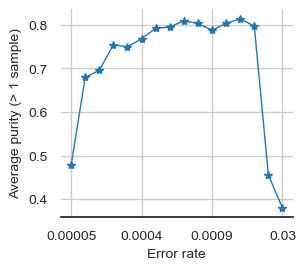

In [89]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.avg_purity_more_than_one_sample.plot(marker='*', lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Average purity (> 1 sample)')

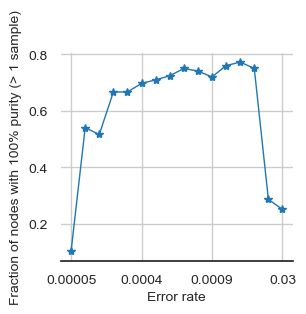

In [88]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.frac_purity_100_more_than_one_sample.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Fraction of nodes with 100% purity (> 1 sample)')
    #plt.xscale('log')

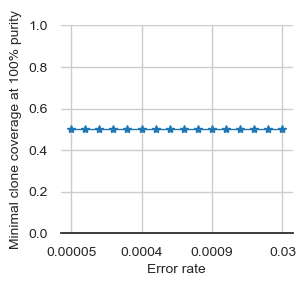

In [87]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.min_clone_coverage.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Minimal clone coverage at 100% purity')
    #plt.xscale('log')
    plt.ylim(0, 1)

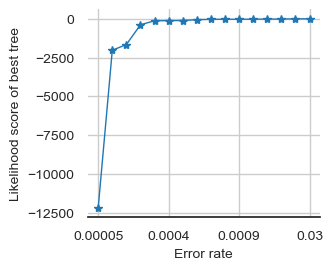

In [52]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Likelihood score of best tree')

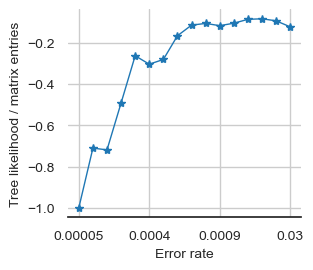

In [54]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood_entries.plot(marker='*', lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Tree likelihood / matrix entries')
    #plt.savefig('../../data/P9855_figures/P9855_lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)

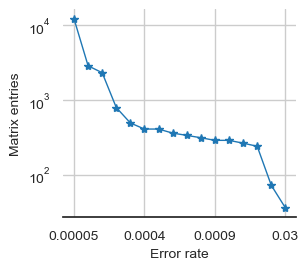

In [55]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.entries.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Matrix entries')
    plt.savefig('../../data/P9855_figures/P9855_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig('figs/performance/train_atac_log_lhood.png', dpi=300)